In [ ]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import plotly.express as px

In [ ]:
auth.authenticate_user()

In [ ]:
project_id = "bionic-aspect-450214-c2"

client = bigquery.Client(project=project_id)

In [ ]:
query = """
    SELECT *
    FROM `bionic-aspect-450214-c2.stock_data.stock_data_combined`
"""

df = client.query(query).to_dataframe()

display(df)

,ticker,date,open_price,close_price,high_price,low_price,volume
0,AAPL,2015-03-02,32.310,32.27,32.57,32.08,192170720
1,AAPL,2015-03-03,32.240,32.34,32.38,32.02,150999600
2,AAPL,2015-03-04,32.280,32.14,32.39,32.08,126353920
3,AAPL,2015-03-05,32.150,31.60,32.19,31.44,225565120
4,AAPL,2015-03-06,32.100,31.65,32.34,31.57,290798720
...,...,...,...,...,...,...,...
63645,XOM,2025-04-07,100.390,102.94,105.80,98.46,35068450
63646,XOM,2025-04-08,105.455,100.77,105.60,99.01,27147750
63647,XOM,2025-04-09,99.370,105.80,106.58,98.13,29964287
63648,XOM,2025-04-10,103.710,99.93,103.78,97.80,33999317


In [ ]:
# Display first 5 rows of the dataset
df.head()

,ticker,date,open_price,close_price,high_price,low_price,volume
0,AAPL,2015-03-02,32.31,32.27,32.57,32.08,192170720
1,AAPL,2015-03-03,32.24,32.34,32.38,32.02,150999600
2,AAPL,2015-03-04,32.28,32.14,32.39,32.08,126353920
3,AAPL,2015-03-05,32.15,31.60,32.19,31.44,225565120
4,AAPL,2015-03-06,32.10,31.65,32.34,31.57,290798720


In [ ]:
# Dataset shape (rows, columns)
rows, cols = df.shape
print(f"The dataset contains {rows} rows and {cols} columns.")

The dataset contains 63650 rows and 7 columns.


In [ ]:
# Column data types
df.dtypes

,0
ticker,object
date,datetime64[ns]
open_price,float64
close_price,float64
high_price,float64
low_price,float64
volume,Int64


In [ ]:
# Check for missing values in each column
df.isnull().sum()

,0
ticker,0
date,0
open_price,0
close_price,0
high_price,0
low_price,0
volume,0


In [ ]:
# Summary statistics for numerical columns (excluding the 'date' column)
df.describe()
df.drop(columns=['date']).describe()

,open_price,close_price,high_price,low_price,volume
count,63650.000000,63650.000000,63650.000000,63650.000000,63650.0
mean,15183.594074,15176.149628,15289.050921,15062.131525,43043310.517533
std,79199.538220,79160.846202,79770.279103,78542.500127,107396326.302314
min,0.480000,0.480000,0.490000,0.480000,43.0
25%,48.942500,48.940000,49.390000,48.500000,4383341.0
50%,115.325000,115.350000,116.485000,114.185000,11333340.0
75%,213.265000,213.305000,215.800000,210.692500,32303160.75
max,803221.530000,806684.000000,808029.500000,795480.201200,3688131600.0


In [ ]:
# Date range (first and last date in the dataset)
start_date = df['date'].min()
end_date = df['date'].max()
start_date, end_date

(Timestamp('2015-03-02 00:00:00'), Timestamp('2025-04-11 00:00:00'))

In [ ]:
# Check for duplicate rows in the dataset
df.duplicated().sum()

np.int64(0)

In [ ]:
# Get unique tickers from the 'ticker' column
unique_tickers = df['ticker'].unique()

# Display the unique tickers
print(unique_tickers)

['AAPL' 'AMZN' 'AVGO' 'BAC' 'BRK.A' 'COST' 'GOOGL' 'HD' 'JNJ' 'JPM' 'LLY'
 'MA' 'META' 'MSFT' 'NFLX' 'NVDA' 'NVO' 'ORCL' 'PG' 'TSLA' 'TSM' 'UNH' 'V'
 'WMT' 'XOM']


In [ ]:
# Function to detect sudden spikes and drops based on a percentage change
def detect_spikes_drops(ticker_data, threshold=0.05):
    # Calculate the daily percentage change in closing price
    ticker_data['pct_change'] = ticker_data['close_price'].pct_change()

    # Detect spikes (positive change > threshold)
    spikes = ticker_data[ticker_data['pct_change'] > threshold]

    # Detect drops (negative change < -threshold)
    drops = ticker_data[ticker_data['pct_change'] < -threshold]

    return spikes, drops

# Function to plot the number of spikes and drops per year
def plot_spikes_drops_per_year(spikes, drops):
    # Extract the year from the date for both spikes and drops
    spikes['year'] = pd.to_datetime(spikes['date']).dt.year
    drops['year'] = pd.to_datetime(drops['date']).dt.year

    # Count spikes and drops per year
    spikes_per_year = spikes['year'].value_counts().sort_index()
    drops_per_year = drops['year'].value_counts().sort_index()

    # Create the plot
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the spikes and drops per year as bar charts
    ax.bar(spikes_per_year.index - 0.2, spikes_per_year.values, width=0.4, label='Spikes', color='green', align='center')
    ax.bar(drops_per_year.index + 0.2, drops_per_year.values, width=0.4, label='Drops', color='red', align='center')

    # Adding data labels to the bars
    for i, v in enumerate(spikes_per_year.values):
        ax.text(spikes_per_year.index[i] - 0.2, v + 0.2, str(v), ha='center', va='bottom', color='black')

    for i, v in enumerate(drops_per_year.values):
        ax.text(drops_per_year.index[i] + 0.2, v + 0.2, str(v), ha='center', va='bottom', color='black')

    # Title and labels
    ax.set_title(f'Number of Spikes and Drops per Year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    ax.legend()

    # Rotate x-ticks for better readability
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Function to display the analysis based on selected ticker
def display_analysis(ticker_name, df, output_widget):
    # Clear previous output from the output widget
    output_widget.clear_output()

    # Check if the ticker is valid
    if ticker_name in df['ticker'].unique():
        ticker_data = df[df['ticker'] == ticker_name]

        # Detect spikes and drops
        spikes, drops = detect_spikes_drops(ticker_data)

        # Plot number of spikes and drops per year
        with output_widget:
            plot_spikes_drops_per_year(spikes, drops)
    else:
        print("Invalid ticker selected.")

# Create a dropdown for selecting the ticker
def create_dropdown(df):
    # Get the unique tickers from the dataset
    tickers = df['ticker'].unique()

    # Create dropdown widget
    ticker_dropdown = widgets.Dropdown(
        options=tickers,
        description='Ticker:',
        disabled=False
    )

    # Create a button to trigger analysis
    button = widgets.Button(description="Analyze")

    # Create an Output widget to display the plot
    output_widget = widgets.Output()

    # Define the button click event handler
    def on_button_click(b):
        # Get the selected ticker
        selected_ticker = ticker_dropdown.value
        # Display analysis for the selected ticker
        display_analysis(selected_ticker, df, output_widget)

    # Attach the button click event
    button.on_click(on_button_click)

    # Display the dropdown, button, and output widget
    display(ticker_dropdown, button, output_widget)

# Run the interactive dropdown interface
create_dropdown(df)

Dropdown(description='Ticker:', options=('AAPL', 'AMZN', 'AVGO', 'BAC', 'BRK.A', 'COST', 'GOOGL', 'HD', 'JNJ',…

Button(description='Analyze', style=ButtonStyle())

Output()

<ipython-input-33-89936aac7644>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-33-89936aac7644>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-33-89936aac7644>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



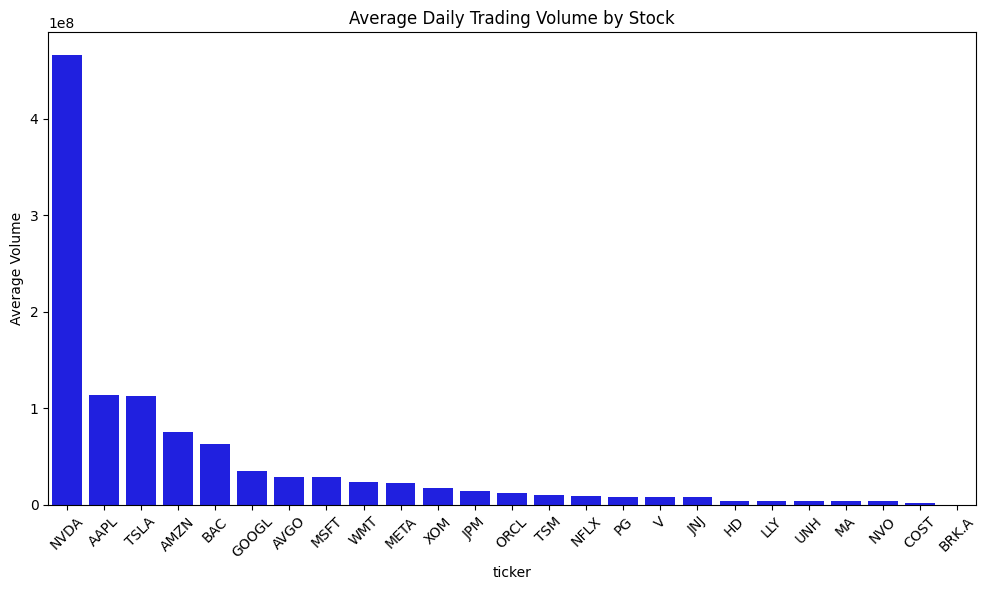

In [ ]:
# Calculate and sort average volume
avg_volume = df.groupby('ticker')['volume'].mean().reset_index()
avg_volume = avg_volume.sort_values(by='volume', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_volume, x='ticker', y='volume', color='blue')

plt.title('Average Daily Trading Volume by Stock')
plt.ylabel('Average Volume')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Sample ticker to industry mapping
ticker_to_industry = {
    'AAPL': 'Technology', 'AMZN': 'Consumer Discretionary', 'AVGO': 'Technology',
    'BAC': 'Financials', 'BRK.A': 'Financials', 'COST': 'Consumer Staples',
    'GOOGL': 'Communication Services', 'HD': 'Consumer Discretionary', 'JNJ': 'Healthcare',
    'JPM': 'Financials', 'LLY': 'Healthcare', 'MA': 'Financials',
    'META': 'Communication Services', 'MSFT': 'Technology', 'NFLX': 'Communication Services',
    'NVDA': 'Technology', 'NVO': 'Healthcare', 'ORCL': 'Technology',
    'PG': 'Consumer Staples', 'TSLA': 'Consumer Discretionary', 'TSM': 'Technology',
    'UNH': 'Healthcare', 'V': 'Financials', 'WMT': 'Consumer Staples', 'XOM': 'Energy'
}

# Filter to selected tickers
selected_tickers = list(ticker_to_industry.keys())
df_filtered = df[df['ticker'].isin(selected_tickers)].copy()

# Convert date to datetime if not already
df_filtered['date'] = pd.to_datetime(df_filtered['date'])

# Group by date and ticker to get daily total volume per ticker
daily_ticker_volume = (
    df_filtered.groupby(['date', 'ticker'])['volume']
    .sum()
    .reset_index()
)

# Map industry
daily_ticker_volume['industry'] = daily_ticker_volume['ticker'].map(ticker_to_industry)

# Now aggregate total volume per industry
industry_volume = (
    daily_ticker_volume.groupby('industry')['volume']
    .sum()
    .reset_index()
)

# Convert to billions
industry_volume['volume_billion'] = industry_volume['volume'] / 1e9
industry_volume = industry_volume.sort_values(by='volume_billion', ascending=True)

# Create horizontal bar chart using Plotly
fig = px.bar(industry_volume,
             x='volume_billion',
             y='industry',
             orientation='h',
             title='Total Trading Volume by Industry',
             labels={'volume_billion': 'Volume (Billion USD)', 'industry': 'Industry'},
             text='volume_billion')

# Adjust layout for better visibility
fig.update_traces(texttemplate='%{text:.2f}B', textposition='inside', insidetextanchor='start')

# Show plot
fig.show()